In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, BatchNormalization, Activation
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU
import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from CyclicLR import CyclicLR

Using TensorFlow backend.


In [3]:
def auc(y_true, y_pred):
    f1 = lambda: tf.constant(0, dtype=tf.float64)
    f2 = lambda: tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    
    r = tf.case([(tf.equal(tf.reduce_sum(y_true), tf.constant(0, dtype=tf.float32)), f1),
                 (tf.equal(tf.reduce_sum(tf.subtract(tf.ones_like(y_true), y_true)), tf.constant(0, dtype=tf.float32)), f1)
                ], default=f2)
    return r

In [4]:
df_train = pd.read_csv('train_with_counts.csv')
y = df_train['target'].values
df_train_X = df_train.drop(columns=['ID_code', 'target'])
df_train_X_normalized = (df_train_X - df_train_X.mean(axis=0))/df_train_X.std(axis=0)

In [5]:
N_vars = 200

def get_data(trn_idx, val_idx, N_vars = 200):
    X_train = []
    X_val = []
    for i in range(N_vars):
        X_train.append(df_train_X_normalized[[f'var_{i}', f'var_{i}_FE']].values[trn_idx])
        X_val.append(df_train_X_normalized[[f'var_{i}', f'var_{i}_FE']].values[val_idx])
    return X_train, X_val
# trn_idx = np.arange(160_000)
# val_idx = np.arange(160_000, 200_000)

In [12]:
def get_model(N_vars=200):
    denseOuts = []
    inputs = []
    for i in range(N_vars):
        inp = Input((2,))
        inputs.append(inp)
        dense_out = Dense(1000)(inp)
        # dense_1000_out = Activation('relu')(dense_out)
        # dense_1000_out = LeakyReLU()(dense_out)
        denseOuts.append(dense_out)
    x = Concatenate()(denseOuts)
    # x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, out)
    return model

In [21]:
def get_model(N_vars=200):
    denseOuts = []
    inputs = []
    for i in range(N_vars):
        inp = Input((2,))
        inputs.append(inp)
        dense_out = Dense(1000)(inp)
        # dense_1000_out = Activation('relu')(dense_out)
        dense_out = LeakyReLU()(dense_out)
        dense_out = Dense(1)(dense_out)
        dense_out = LeakyReLU()(dense_out)
        denseOuts.append(dense_out)
    x = Concatenate()(denseOuts)
    # x = BatchNormalization()(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, out)
    return model

In [22]:
best_model_file_name = 'best_full_model.h5'

In [23]:
model = get_model(N_vars=2)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_407 (InputLayer)          (None, 2)            0                                            
__________________________________________________________________________________________________
input_408 (InputLayer)          (None, 2)            0                                            
__________________________________________________________________________________________________
dense_414 (Dense)               (None, 1000)         3000        input_407[0][0]                  
__________________________________________________________________________________________________
dense_416 (Dense)               (None, 1000)         3000        input_408[0][0]                  
__________________________________________________________________________________________________
leaky_re_l

In [24]:
# Epoch 00050: val_auc improved from 0.91503 to 0.91511, saving model to best_full_model.h5
# Epoch 00017: val_auc did not improve from 0.91834
# Epoch 00012: val_auc improved from 0.91837 to 0.91853, saving model to best_full_model.h5
# Epoch 00029: val_auc did not improve from 0.91857

In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epochs = 70
patience = 15
bs = 512
for fold, (trn_idx, val_idx) in enumerate(skf.split(df_train_X_normalized, y)):
    print('###############################################')
    print(f'##################Fold {fold}#######################')
    print('###############################################')
    X_train, X_val = get_data(trn_idx, val_idx)
    print('Got train and val data!')
    lrs = [0.001, 0.0001, 0.00005]
    model = get_model()
    for lr in lrs:
        model.compile(Adam(lr=lr, decay=0), loss='binary_crossentropy', metrics=[auc])
        es = EarlyStopping(monitor='val_auc', patience=patience, mode='max', verbose=1)
        mc = ModelCheckpoint(best_model_file_name, monitor='val_auc', mode='max', verbose=1, save_best_only=True)
        tr_iter_in_epoch = 160_000//bs
        clr = CyclicLR(base_lr=0.0001, max_lr=0.005, step_size=4*tr_iter_in_epoch, mode='exp_range', gamma=0.99994)
        # First train
        model.fit(X_train, y[trn_idx], 
              epochs=epochs, batch_size=bs, 
              verbose=1,
              callbacks = [clr],
#               callbacks = [es, 
#                            mc], 
#                            #clr],
              validation_data=(X_val, y[val_idx]))
        print(f'Finish training with lr {lr}')
        model = get_model()
        # Load weights from ModelCheckpoint
        model.load_weights(best_model_file_name)
        # Save them to disk
        model.save_weights(f'big_NN_2_fold_{fold}_lr_{lr}.hdf5')
        print('weights saved')

###############################################
##################Fold 0#######################
###############################################
Got train and val data!
Train on 159999 samples, validate on 40001 samples
Epoch 1/70
  1536/159999 [..............................] - ETA: 21:48 - loss: 0.7000 - auc: 0.5097

/home/usuario/anaconda3/envs/gpu/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.384074). Check your callbacks.
  % delta_t_median)


159999/159999 [==============================] - 58s 360us/step - loss: 0.2819 - auc: 0.7770 - val_loss: 0.2269 - val_auc: 0.8669
Epoch 2/70
159999/159999 [==============================] - 44s 273us/step - loss: 0.2238 - auc: 0.8744 - val_loss: 0.2200 - val_auc: 0.8790
Epoch 3/70
159999/159999 [==============================] - 44s 274us/step - loss: 0.2166 - auc: 0.8838 - val_loss: 0.2151 - val_auc: 0.8840
Epoch 4/70
159999/159999 [==============================] - 44s 274us/step - loss: 0.2143 - auc: 0.8861 - val_loss: 0.2118 - val_auc: 0.8889
Epoch 5/70
159999/159999 [==============================] - 44s 274us/step - loss: 0.2103 - auc: 0.8910 - val_loss: 0.2091 - val_auc: 0.8914
Epoch 6/70
159999/159999 [==============================] - 44s 274us/step - loss: 0.2051 - auc: 0.8965 - val_loss: 0.2021 - val_auc: 0.8979
Epoch 7/70
159999/159999 [==============================] - 44s 274us/step - loss: 0.1999 - auc: 0.9021 - val_loss: 0.1991 - val_auc: 0.9017
Epoch 8/70
159999/159999

KeyboardInterrupt: 

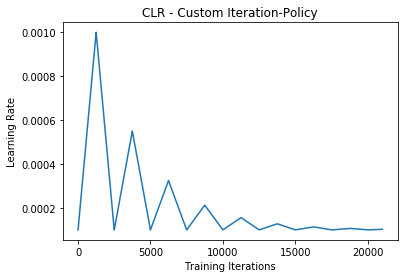

In [50]:
from matplotlib import pyplot as plt
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Iteration-Policy")
plt.plot(clr.history['iterations'], clr.history['lr'])

In [46]:
tr_it_per_epoch = 160_000//(bs)
print(tr_it_per_epoch)

625


In [ ]:
###############################################
##################Fold 0#######################
###############################################
Got train and val data!

Epoch 00001: val_auc improved from -inf to 0.88278, saving model to best_full_model.h5

Epoch 00002: val_auc improved from 0.88278 to 0.89449, saving model to best_full_model.h5

Epoch 00003: val_auc improved from 0.89449 to 0.89904, saving model to best_full_model.h5

Epoch 00004: val_auc improved from 0.89904 to 0.90180, saving model to best_full_model.h5

Epoch 00005: val_auc improved from 0.90180 to 0.90400, saving model to best_full_model.h5

Epoch 00006: val_auc improved from 0.90400 to 0.90428, saving model to best_full_model.h5

Epoch 00007: val_auc improved from 0.90428 to 0.90601, saving model to best_full_model.h5

Epoch 00008: val_auc did not improve from 0.90601

Epoch 00009: val_auc improved from 0.90601 to 0.90606, saving model to best_full_model.h5

Epoch 00010: val_auc improved from 0.90606 to 0.90734, saving model to best_full_model.h5

Epoch 00011: val_auc did not improve from 0.90734

Epoch 00012: val_auc improved from 0.90734 to 0.90926, saving model to best_full_model.h5

Epoch 00013: val_auc did not improve from 0.90926

Epoch 00014: val_auc did not improve from 0.90926

Epoch 00015: val_auc did not improve from 0.90926

Epoch 00016: val_auc improved from 0.90926 to 0.90963, saving model to best_full_model.h5

Epoch 00017: val_auc improved from 0.90963 to 0.90992, saving model to best_full_model.h5

Epoch 00018: val_auc did not improve from 0.90992

Epoch 00019: val_auc improved from 0.90992 to 0.91158, saving model to best_full_model.h5

Epoch 00020: val_auc did not improve from 0.91158

Epoch 00021: val_auc improved from 0.91158 to 0.91254, saving model to best_full_model.h5

Epoch 00022: val_auc did not improve from 0.91254

Epoch 00023: val_auc improved from 0.91254 to 0.91382, saving model to best_full_model.h5

Epoch 00024: val_auc did not improve from 0.91382

Epoch 00025: val_auc did not improve from 0.91382

Epoch 00026: val_auc did not improve from 0.91382

Epoch 00027: val_auc did not improve from 0.91382

Epoch 00028: val_auc did not improve from 0.91382

Epoch 00029: val_auc did not improve from 0.91382

Epoch 00030: val_auc did not improve from 0.91382

Epoch 00031: val_auc did not improve from 0.91382

Epoch 00032: val_auc did not improve from 0.91382

Epoch 00033: val_auc did not improve from 0.91382

Epoch 00034: val_auc did not improve from 0.91382

Epoch 00035: val_auc did not improve from 0.91382

Epoch 00036: val_auc did not improve from 0.91382

Epoch 00037: val_auc improved from 0.91382 to 0.91443, saving model to best_full_model.h5

Epoch 00038: val_auc did not improve from 0.91443

Epoch 00044: val_auc did not improve from 0.91549

Epoch 00045: val_auc did not improve from 0.91549

Epoch 00046: val_auc did not improve from 0.91549

Epoch 00047: val_auc did not improve from 0.91549

Epoch 00048: val_auc did not improve from 0.91549

Epoch 00049: val_auc did not improve from 0.91549

Epoch 00050: val_auc did not improve from 0.91549

Epoch 00051: val_auc did not improve from 0.91549

Epoch 00052: val_auc did not improve from 0.91549

Epoch 00053: val_auc did not improve from 0.91549

Epoch 00054: val_auc did not improve from 0.91549

Epoch 00055: val_auc did not improve from 0.91549

Epoch 00056: val_auc did not improve from 0.91549

Epoch 00057: val_auc did not improve from 0.91549

Epoch 00058: val_auc improved from 0.91549 to 0.91555, saving model to best_full_model.h5

Epoch 00059: val_auc did not improve from 0.91555

Epoch 00060: val_auc improved from 0.91555 to 0.91606, saving model to best_full_model.h5

Epoch 00061: val_auc did not improve from 0.91606

Epoch 00062: val_auc did not improve from 0.91606

Epoch 00063: val_auc did not improve from 0.91606

Epoch 00064: val_auc did not improve from 0.91606

Epoch 00065: val_auc did not improve from 0.91606

Epoch 00066: val_auc did not improve from 0.91606

Epoch 00067: val_auc did not improve from 0.91606

Epoch 00068: val_auc did not improve from 0.91606

Epoch 00069: val_auc did not improve from 0.91606

Epoch 00070: val_auc improved from 0.91606 to 0.91670, saving model to best_full_model.h5
Finish training with lr 0.001
weights saved

Epoch 00001: val_auc improved from -inf to 0.91868, saving model to best_full_model.h5

Epoch 00002: val_auc improved from 0.91868 to 0.91898, saving model to best_full_model.h5

Epoch 00003: val_auc did not improve from 0.91898

Epoch 00004: val_auc did not improve from 0.91898

Epoch 00005: val_auc improved from 0.91898 to 0.91899, saving model to best_full_model.h5

Epoch 00006: val_auc did not improve from 0.91899

Epoch 00007: val_auc did not improve from 0.91899

Epoch 00008: val_auc did not improve from 0.91899

Epoch 00009: val_auc improved from 0.91899 to 0.91905, saving model to best_full_model.h5

Epoch 00010: val_auc did not improve from 0.91905

Epoch 00011: val_auc did not improve from 0.91905

Epoch 00012: val_auc did not improve from 0.91905

Epoch 00013: val_auc did not improve from 0.91905

Epoch 00014: val_auc did not improve from 0.91905

Epoch 00015: val_auc did not improve from 0.91905

Epoch 00016: val_auc did not improve from 0.91905

Epoch 00017: val_auc did not improve from 0.91905

Epoch 00018: val_auc did not improve from 0.91905

Epoch 00019: val_auc did not improve from 0.91905

Epoch 00020: val_auc did not improve from 0.91905

Epoch 00021: val_auc did not improve from 0.91905

Epoch 00022: val_auc did not improve from 0.91905

Epoch 00023: val_auc did not improve from 0.91905

Epoch 00024: val_auc did not improve from 0.91905
Epoch 00024: early stopping
Finish training with lr 0.0001
weights saved

Epoch 00001: val_auc improved from -inf to 0.91900, saving model to best_full_model.h5

Epoch 00002: val_auc improved from 0.91900 to 0.91900, saving model to best_full_model.h5

Epoch 00003: val_auc did not improve from 0.91900

Epoch 00004: val_auc did not improve from 0.91900

Epoch 00005: val_auc did not improve from 0.91900

Epoch 00006: val_auc did not improve from 0.91900

Epoch 00007: val_auc did not improve from 0.91900

Epoch 00008: val_auc did not improve from 0.91900

Epoch 00009: val_auc did not improve from 0.91900

Epoch 00010: val_auc did not improve from 0.91900

Epoch 00011: val_auc did not improve from 0.91900

Epoch 00012: val_auc did not improve from 0.91900

Epoch 00013: val_auc did not improve from 0.91900

Epoch 00014: val_auc did not improve from 0.91900

Epoch 00015: val_auc did not improve from 0.91900

Epoch 00016: val_auc did not improve from 0.91900

Epoch 00017: val_auc did not improve from 0.91900
Epoch 00017: early stopping
Finish training with lr 5e-05
weights saved